# Notebook for Programming in Problem 4
Welcome to the programming portion of the assignment! Each assignment throughout the semester will have a written portion and a programming portion. We will be using [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true), so if you have never used it before, take a quick look through this introduction: [Working with Google Colab](https://docs.google.com/document/d/1LlnXoOblXwW3YX-0yG_5seTXJsb3kRdMMRYqs8Qqum4/edit?usp=sharing).

## Learning Objectives
In this problem, we will use [PyTorch](https://pytorch.org/) to implement a sequence-to-sequence (seq2seq) transformer model to build a nerual machine translation (NMT) system, which translates from French to English.

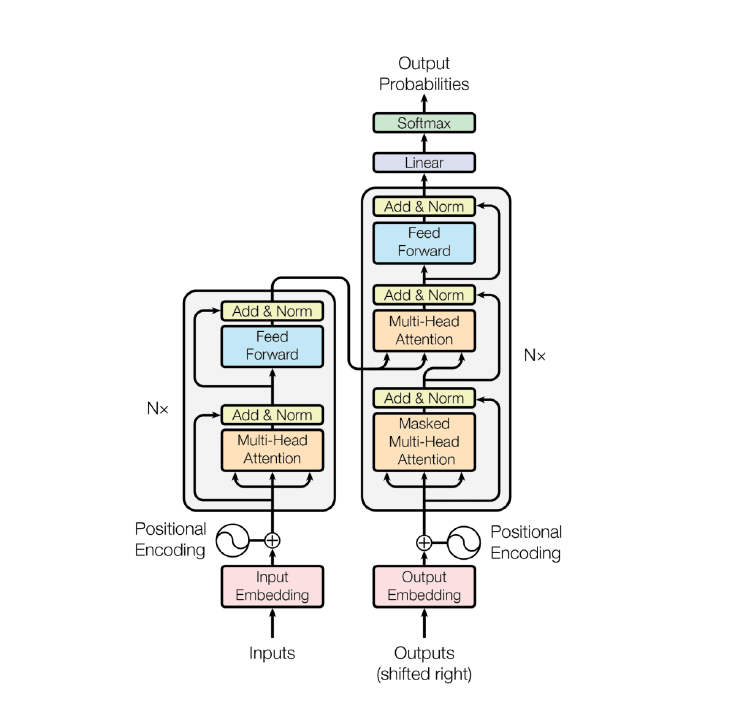

## Writing Code
Look for the keyword "TODO" and fill in your code in the empty space.
You can edit code in the other parts of the notebook too, which can be useful for debugging, but be careful to avoid breaking the provided code.

## Installing Packages

Install PyTorch using pip. See [https://pytorch.org/](https://pytorch.org/) if you want to install it on your computer.
In addition, we will also be needing [huggingface](https://huggingface.co/)'s `transformers` and `datasets` libraries, and [nltk](https://www.nltk.org/) to compute the BLEU score.

In [ ]:
# Pytorch is typically already installed in Google Colab (uncomment to install):
# !pip install torch==1.8.0
# or for GPU support:
# !pip install torch==1.8.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
!pip install transformers==4.27.0
!pip install datasets==2.10.0
# NLTK is typically also already installed in Google Colab (uncomment to install):
# !pip install nltk==3.8.1

## Download NMT data

We first download the data for NMT, which contains pairs of parallel sentences.

In [ ]:
!wget --quiet https://princeton-nlp.github.io/cos484/assignments/a4/resources.zip
!unzip -qo resources.zip

## Data preprocessing
In this section we will write code to load and tokenize the data for NMT.


The parallel data is provided as huggingface datasets, one for each split of `train`, `validation` and `test`. We load it via the `load_from_disk` method and inspect its features. If you'd like to know more about these dataset objects, have a look at [this tutorial](https://huggingface.co/docs/datasets/access).

In [ ]:
from datasets import load_from_disk  # Import function to load datasets from disk
raw_text_datasets = load_from_disk("resources/parallel_en_fr_corpus")  # Load the parallel English-French corpus dataset
print("Summary of splits:", raw_text_datasets)  # Print summary of dataset splits
print("First training example:", raw_text_datasets["train"][0])  # Print the first training example to inspect its structure

Summary of splits: DatasetDict({
    train: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 8701
    })
    validation: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 485
    })
    test: Dataset({
        features: ['text_en', 'text_fr'],
        num_rows: 486
    })
})
First training example: {'text_en': 'i m tough .', 'text_fr': 'je suis dure .'}


In [ ]:
# Inspecting the dataset to check the keys
print("Keys in dataset:", raw_text_datasets["train"].features)  # Print the keys/features of the dataset

# Inspecting the first example to understand its structure
print("First training example:", raw_text_datasets["train"][0])  # Print the first training example again

Keys in dataset: {'text_en': Value(dtype='string', id=None), 'text_fr': Value(dtype='string', id=None)}
First training example: {'text_en': 'i m tough .', 'text_fr': 'je suis dure .'}


You are also provided with two pre-trained tokenizers for the source and target languages respectively, which we can load with the hugginface transfomers library. [This tutorial](https://huggingface.co/docs/transformers/preprocessing#natural-language-processing) provides an introduction to using pre-trained tokenizers and the powerful `AutoTokenizer` class. The tokenizers are based on byte-pair encodings which break words into smaller units. This is aimed at reducing the sparsity of words, as subwords can be shared between different rare words. If you are interested in learning more, see the paper [Neural Machine Translation of Rare Words with Subword Units](https://www.aclweb.org/anthology/P16-1162.pdf).

In [ ]:
from transformers import AutoTokenizer  # Import AutoTokenizer from transformers library
source_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_fr")  # Load the tokenizer for French
target_tokenizer = AutoTokenizer.from_pretrained("resources/tokenizer_en")  # Load the tokenizer for English

print("Vocab size of source language:", source_tokenizer.vocab_size)  # Print the vocabulary size of the source language tokenizer
print("Vocab size of target language:", target_tokenizer.vocab_size)  # Print the vocabulary size of the target language tokenizer

# As a demonstration, we will the following English sentence to tokens.
example_sentence = "we have an example"  # Example sentence in English
tokenizer_output = target_tokenizer(example_sentence)  # Tokenize the example sentence using the English tokenizer
print("\n*** Example ***")
print("Example sentence:", example_sentence)  # Print the example sentence
print("Tokenizer output:", tokenizer_output)  # Print the tokenizer output, which includes token IDs

# We convert every token id to its associated string, but find the special character ▁ which indicates the beginning of a word.
# Note that very common words are represented by a single token, while others are split into subunits due to the small vocab size.
# Also note that the tokenizer already adds special tokens to the beginning and end of the sentence.
decoded_sequence = [target_tokenizer.decode(token) for token in tokenizer_output["input_ids"]]  # Decode each token ID to its string representation
print("Tokens:", decoded_sequence)  # Print the decoded tokens

# By replacing the special character ▁ with whitespace, we can reconstruct a legible sentence,
# which differs from the original example by special tokens, including <unk> tokens, and minor whitespace differences.
reconstructed = "".join(decoded_sequence).replace("▁", " ")  # Reconstruct the sentence by replacing the special character with a space
print("Reconstructed sentence", reconstructed)  # Print the reconstructed sentence

Vocab size of source language: 3200
Vocab size of target language: 3200

*** Example ***
Example sentence: we have an example
Tokenizer output: {'input_ids': [1, 64, 324, 103, 266, 1490, 92, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1]}
Tokens: ['<s>', '▁we', '▁have', '▁an', '▁ex', 'amp', 'le', '</s>']
Reconstructed sentence <s> we have an example</s>


We now want to convert the entire dataset to token ids.
Specifically, we want to use the tokenizers to create a dataset with
features "encoder_input_ids" and "decoder_input_ids", which both have type `List[int]`
and which will later be the inputs to our encoder-decoder model. We will implement this using the powerful `map` function. You can find its API reference [here](https://huggingface.co/docs/datasets/v2.10.0/en/package_reference/main_classes#datasets.Dataset.map).

In [ ]:
from typing import Dict, List  # Import typing for type annotations

def map_example(example: Dict[str, str]) -> Dict[str, List[int]]:
    # TODO: Tokenize the source and target text for an entry in the parallel dataset
    # and return a dictionary with the keys "encoder_input_ids" and "decoder_input_ids".
    # You can use `source_tokenizer` and `target_tokenizer`
    encoder_input_ids = source_tokenizer.encode(example["text_fr"])  # Tokenize the French text
    decoder_input_ids = target_tokenizer.encode(example["text_en"])  # Tokenize the English text
    return {"encoder_input_ids": encoder_input_ids, "decoder_input_ids": decoder_input_ids}  # Return the tokenized input IDs

# When mapped is applied to the DatasetDict object, it will apply `map` separately to each split.
tokenized_datasets = raw_text_datasets.map(map_example, batched=False)  # Apply the map function to tokenize each example in the dataset

# The `remove_columns` removes the existing text features from the new dataset, as they are no longer needed.
tokenized_datasets = tokenized_datasets.remove_columns(raw_text_datasets.column_names["train"])  # Remove the original text columns

# Sanity checks on the new dataset
assert set(tokenized_datasets.column_names["train"]) == {"decoder_input_ids", "encoder_input_ids"}  # Ensure the new dataset has the expected columns
assert len(tokenized_datasets["train"]) == len(raw_text_datasets["train"])  # Ensure the number of examples remains the same

## Transformer model for NMT

We will now implement a encoder-decoder transformer model.
We already provide code for the Feedforward Layers and Transformer Blocks, but you will have to implement the MultiHeadAttention and Embedding layer from scratch, as well as registering all the layers in the final EncoderDecoderModel. Pay attention to doc-strings and typing information to understand the context and purpose of each missing code block!

In [ ]:
import torch  # Import PyTorch
import torch.nn as nn  # Import neural network module from PyTorch
import torch.nn.functional as F  # Import functional module from PyTorch
import math  # Import math module
from typing import Optional, Dict, List, Tuple  # Import typing for type annotations

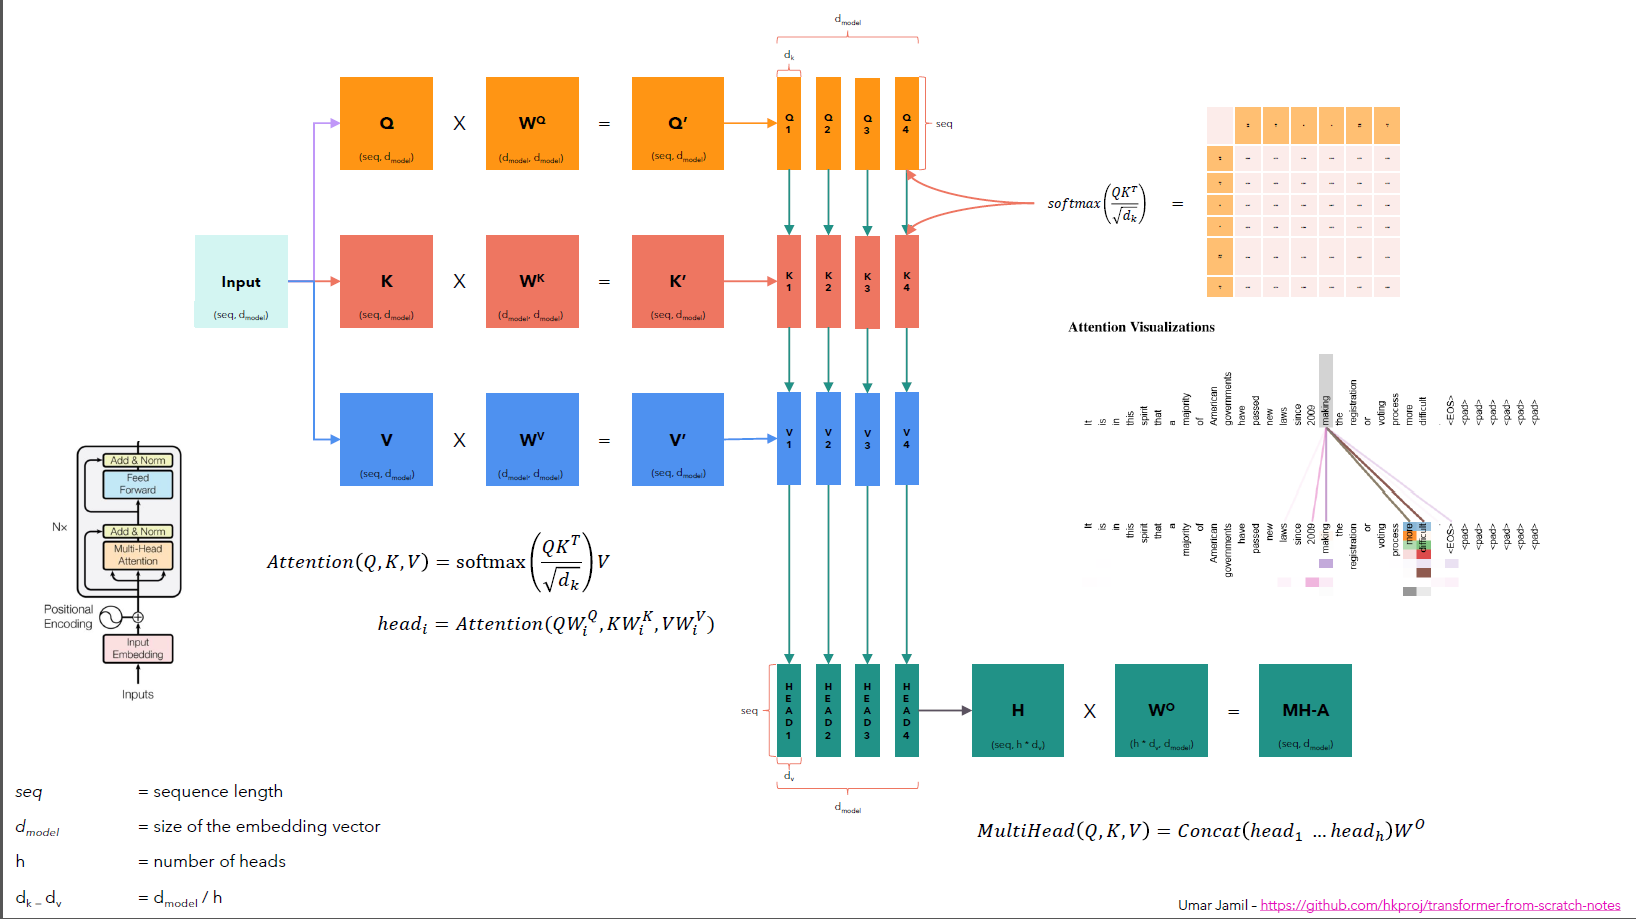

In [ ]:
# Defines a multi-head attention mechanism with optional causal and cross-attention capabilities.
class MultiHeadAttention(nn.Module):
    # Initializes the multi-head attention layer with given parameters and sets up linear layers for query, key, value, and output projections.
    def __init__(self,
                 hidden_size: int,
                 num_attention_heads: int,
                 is_causal_attention: bool = False,
                 is_cross_attention: bool = False):
        """
        Defines a flexible multi-head attention layer.

        This layer performs multi-head attention with options for causal and cross-attention.
        Parameters are defined for query, key, value, and output projections.

        Args:
            hidden_size: The dimensionality of the input vectors.
            num_attention_heads: The number of attention heads.
            is_causal_attention: Whether to use causal masking, where tokens cannot attend to future tokens.
            is_cross_attention: Whether to use cross-attention, where key and value vectors come from encoder outputs.
        """
        super().__init__()  # Initialize the parent class
        assert hidden_size % num_attention_heads == 0, "The hidden size must be divisible by the number of attention heads."  # Ensure hidden_size is divisible by num_attention_heads
        self.head_dim = hidden_size // num_attention_heads  # Dimension of query and key vectors per head

        # TODO Initialize the module and its parameters here.
        # This module should be able to handle both full self-attention, causal masked self-attention and cross-attention.
        # IMPORTANT: You are not allowed to use `nn.MultiheadAttention` or `nn.functional.scaled_dot_product_attention`!

        self.hidden_size = hidden_size  # Store hidden_size
        self.num_attention_heads = num_attention_heads  # Store num_attention_heads
        self.is_causal_attention = is_causal_attention  # Store is_causal_attention
        self.is_cross_attention = is_cross_attention  # Store is_cross_attention

        # Define linear layers for query, key, value, and output projections
        self.wq = nn.Linear(hidden_size, hidden_size)  # Linear layer for query projection
        self.wk = nn.Linear(hidden_size, hidden_size)  # Linear layer for key projection
        self.wv = nn.Linear(hidden_size, hidden_size)  # Linear layer for value projection
        self.wo = nn.Linear(hidden_size, hidden_size)  # Linear layer for output projection

    # Generates a mask for causal attention to ensure that tokens cannot attend to future tokens.
    def causal_attention_mask(self,
                              sequence_length: int,
                              device: Optional[torch.device] = None) -> torch.FloatTensor:
        """
        Return a Float tensor that can be added to the attention scores for causal masking.

        Args:
            sequence_length: Width and height of the attention mask tensor.
            device: Which torch device the resulting tensor should be on (important if you use GPU).

        Returns:
            A Float tensor of shape (1, 1, sequence_length, sequence_length) on device `device`,
            where entries above the diagonal contain large negative values,
            meaning a query at position i can't attend to a key at position j>i.
        """
        # TODO Implement the forward function.
        # IMPORTANT: For full credit, you should not use python loops.
        #
        # Hint 1: You can pick an arbitrary large value (e.g., -10^{6}), but note that
        #         using `float("-inf")` might lead to numerical issues and 'nan' values during training.
        #
        # Hint 2: Useful pytorch functions for this are `torch.arange` or `torch.triu`.
        #
        # Hint 3: You can move the tensor you create to a device by calling `tensor.to(device)`
        #
        # You should use this function in `forward` and use the returned tensor to implement causal masking
        # by adding it to the un-normalized attention scores of shape (batch_size, num_heads, sequence_length, sequence_length),
        # as torch will handle broadcasting and expand the first two dimensions to batch size and num_heads.
        #
        # You will the masking tensor to be on the same device as the attention scores's device,
        # which you can via the attribute `tensor.device`.

        mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1)  # Create an upper triangular matrix of ones
        mask = mask * (-10**9)  # Scale the mask by a large negative value

        if device is not None:
            mask = mask.to(device)  # Move mask to the specified device if provided
        return mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions and return mask

    # Computes the scaled dot-product attention and returns the output vectors and attention weights.
    def forward(self,
                hidden_states: torch.FloatTensor,
                key_padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None) -> Tuple[torch.FloatTensor, torch.FloatTensor]:
        """
        Computes scaled dot-product attention and returns the output of the attention layer.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the input vectors to the layer.
            key_padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                              A `True` entry means that this token should be ignored for the purpose of attention.
                              In the case of cross-attention, the tensor has shape (batch_size, encoder_sequence_length).
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size).
                             The output vectors of the encoder and only passed if the layer performs cross-attention.

        Returns:
            A (layer_output, attention_weights) where layer_output is a tensor of shape (batch_size, sequence_length, hidden_size)
            and attention_weights are the normalized attention scores in the form of
            a tensor of shape (batch_size, num_attention_heads, number_of_query_tokens, number_of_key_tokens).
        """

        # TODO Implement the forward function.
        # IMPORTANT: For full credit, you should not use python loops. Furthermore,
        #            you are not allowed to use `nn.MultiheadAttention` or `nn.functional.scaled_dot_product_attention`!
        #
        # Hint 1: Use `torch.reshape` to add a new axis for the attention head,
        #         which will allow you to process all attention heads in parallel.
        #
        # Hint 2: You can use `torch.transpose` to swap the order of two axes,
        #         As the attention head dimension should be next to the batch size,
        #         see the shape of the output attention weights.
        #
        # Hint 3: `torch.bmm(matrix1, matrix2)` is useful for computing batched matrix multiplications
        #         If matrix1 has shape (B, M, N) and matrix2 has shape (B, N, P),
        #         it performs `B` matrix multiplications and outputs a tensor of shape (B, M, P).
        #         Alternatively, `torch.einsum` should be very useful.
        #         (We really encourage you to check out the documentation of `torch.einsum`,
        #         it can really make your life easier here.)

        batch_size, sequence_length, d_model = hidden_states.size()  # Get batch size, sequence length, and hidden size

        if self.is_cross_attention:  # If performing cross-attention
            if encoder_outputs is not None:
                key_value = encoder_outputs  # Use encoder outputs as key and value
                key_seq_length = encoder_outputs.size(1)  # Get sequence length of encoder outputs
            else:
                raise ValueError("Need encoder_outputs for cross-attention")  # Raise error if encoder_outputs not provided
        else:
            key_value = hidden_states  # Use hidden states as key and value for self-attention
            key_seq_length = sequence_length  # Sequence length is the same as hidden states

        key = self.wk(key_value)  # Compute key projections
        query = self.wq(hidden_states)  # Compute query projections
        value = self.wv(key_value)  # Compute value projections

        # Split into heads: (batch, seq_length, d_model) -> (batch, seq_length, num_heads, head_dim) -> (batch, num_heads, seq_length, head_dim)
        query = query.view(batch_size, sequence_length, self.num_attention_heads, self.head_dim).transpose(1, 2)
        key = key.view(batch_size, key_seq_length, self.num_attention_heads, self.head_dim).transpose(1, 2)
        value = value.view(batch_size, key_seq_length, self.num_attention_heads, self.head_dim).transpose(1, 2)

        # Compute attention scores: (batch, num_heads, seq_length, seq_length)
        attention_scores = torch.einsum('bhqd,bhkd->bhqk', query, key) / math.sqrt(self.head_dim)

        if self.is_causal_attention:  # Apply causal attention mask if specified
            mask = self.causal_attention_mask(sequence_length, device=hidden_states.device)
            attention_scores += mask

        if key_padding_mask is not None:  # Apply key padding mask if provided
            attention_scores = attention_scores.masked_fill(key_padding_mask.unsqueeze(1).unsqueeze(2), -10**9)

        attention_weights = nn.Softmax(dim=-1)(attention_scores)  # Normalize attention scores using softmax

        x = torch.matmul(attention_weights, value)  # Compute weighted sum of value vectors
        x = x.transpose(1, 2).contiguous().view(x.shape[0], sequence_length, self.hidden_size)  # Reshape and combine heads

        output = self.wo(x)  # Apply output projection
        return output, attention_weights  # Return output and attention weights

Before we move on to the other modules, you should implement a sanity check for your attention implementation:
1. We check the dimensions of the output of the layer and
2. We plot the attention weights to some toy embedding inputs.
We assume that the last token in the encoder and the last two tokens in the decoder are pad tokens.

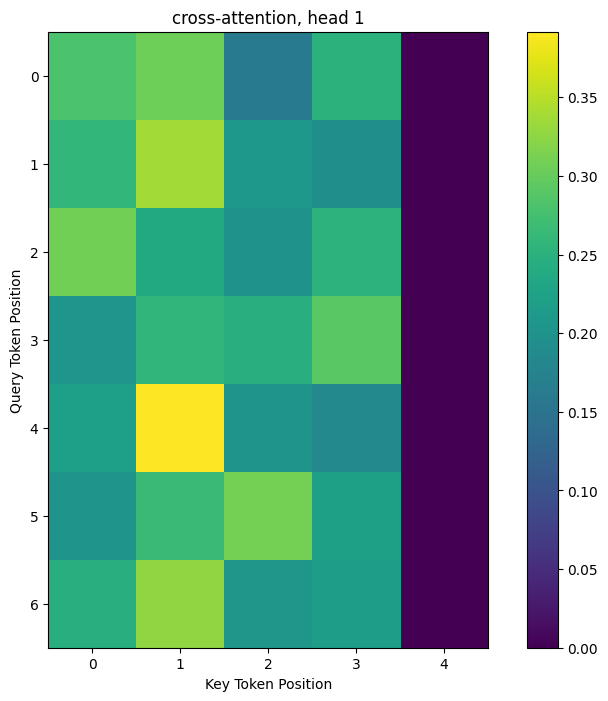

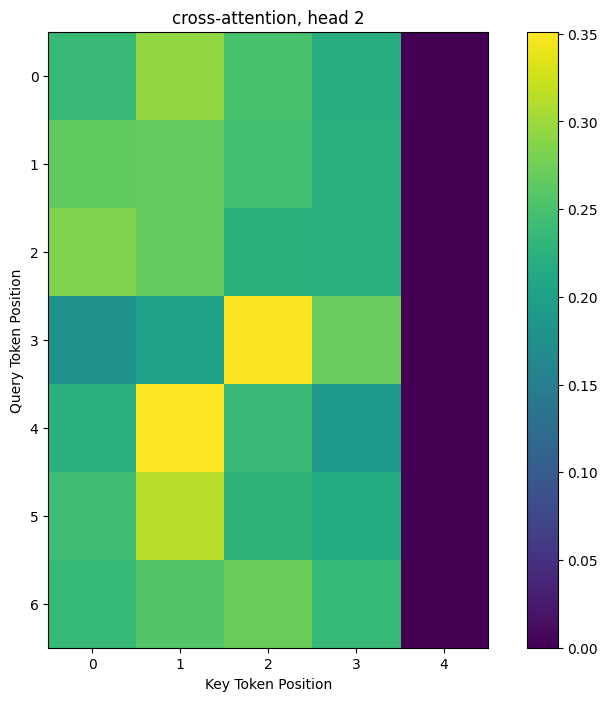

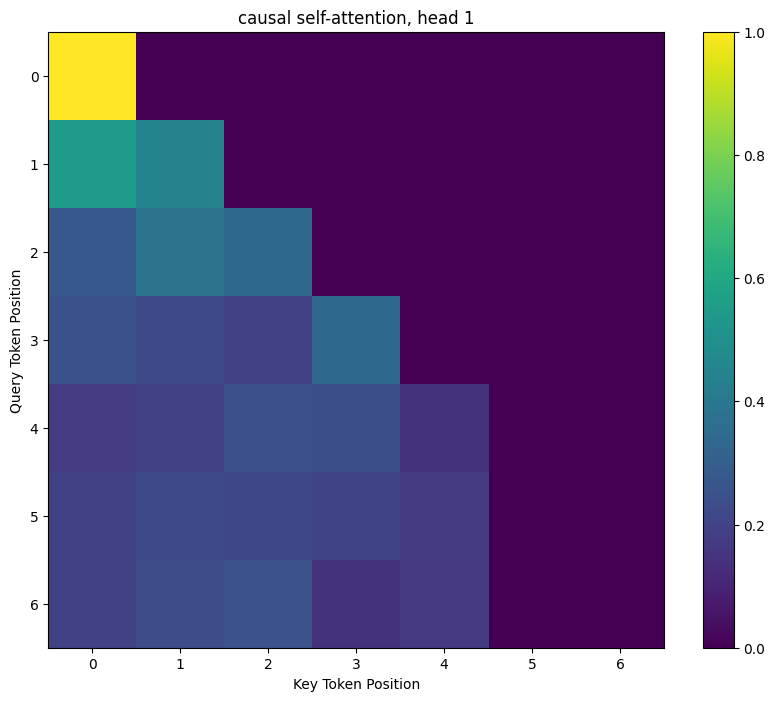

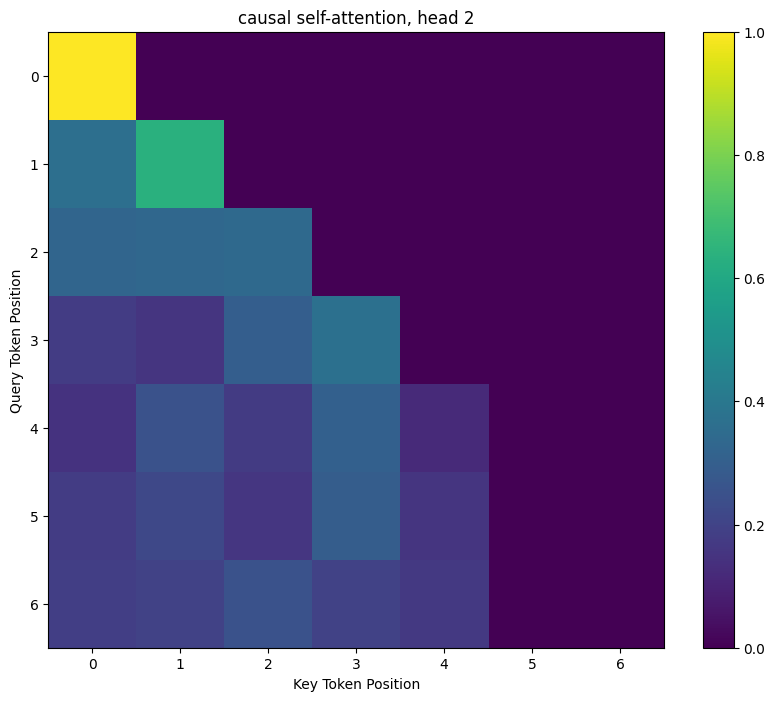

In [ ]:
# Set parameters for the attention mechanism
embed_dim = 8  # Dimension of the embeddings
num_heads = 2  # Number of attention heads
batch_size = 1  # Batch size
encoder_seq_length = 5  # Length of the encoder sequence
decoder_seq_length = 7  # Length of the decoder sequence

# Create random input tensors for the encoder and decoder
encoder_outputs = torch.randn(batch_size, encoder_seq_length, embed_dim)  # Encoder output tensor
decoder_inputs = torch.randn(batch_size, decoder_seq_length, embed_dim)  # Decoder input tensor

# Create padding masks for the encoder and decoder
encoder_padding_mask = torch.zeros(batch_size, encoder_seq_length, dtype=torch.bool)  # Encoder padding mask
encoder_padding_mask[:, -1] = True  # The last encoder token is a padding token

decoder_padding_mask = torch.zeros(batch_size, decoder_seq_length, dtype=torch.bool)  # Decoder padding mask
decoder_padding_mask[:, -2:] = True  # The last two decoder tokens are padding tokens

# Initialize the MultiHeadAttention layers
cross_attention = MultiHeadAttention(embed_dim, num_heads, is_cross_attention=True)  # Cross-attention layer
causal_attention = MultiHeadAttention(embed_dim, num_heads, is_causal_attention=True)  # Causal attention layer

# Apply the cross-attention layer
cross_attention_out, cross_attention_weights = cross_attention(decoder_inputs, encoder_padding_mask, encoder_outputs)
# Apply the causal attention layer
causal_attention_out, causal_attention_weights = causal_attention(decoder_inputs, decoder_padding_mask)

# Ensure the output shapes are as expected
assert cross_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)  # Check cross-attention output shape
assert cross_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, encoder_seq_length)  # Check cross-attention weights shape
assert causal_attention_out.shape == (batch_size, decoder_seq_length, embed_dim)  # Check causal attention output shape
assert causal_attention_weights.shape == (batch_size, num_heads, decoder_seq_length, decoder_seq_length)  # Check causal attention weights shape

# Check that the attention weights are normalized (sum to 1)
assert torch.isclose(cross_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()  # Check normalization of cross-attention weights
assert torch.isclose(causal_attention_weights.sum(dim=-1), torch.tensor(1.0)).all()  # Check normalization of causal attention weights

# Check if the attention masking works
assert torch.isclose(cross_attention_weights[:, :, :, -1], torch.tensor(0.0)).all()  # Ensure the last encoder token is not attended to
assert torch.isclose(causal_attention_weights[:, :, :, -2:], torch.tensor(0.0)).all()  # Ensure the last two decoder tokens are not attended to
assert torch.isclose(causal_attention_weights[:, :, 2, 3:], torch.tensor(0.0)).all()  # Ensure future tokens are not attended to

import matplotlib.pyplot as plt
# Creates and displays a heatmap of the attention weights for visualization purposes.
def plot_attention_matrix(attention_matrix, title):
    """
    Creates a new figure and plots the normalized attention weights as a heatmap.

    Args:
        attention_matrix: A numpy array of shape (number_of_query_tokens, number_of_key_tokens)
        title: The title of the plot.
    """
    # TODO Implement this function

    plt.figure(figsize=(10, 8))  # Create a new figure
    plt.imshow(attention_matrix, cmap='viridis')  # Plot the attention matrix as a heatmap
    plt.colorbar()  # Add a colorbar to show the scale
    plt.xlabel("Key Token Position")  # Label x-axis
    plt.ylabel("Query Token Position")  # Label y-axis
    plt.title(title)  # Add a title to the plot
    plt.show()  # Display the plot

# Plot the attention matrices for each head
plot_attention_matrix(cross_attention_weights[0, 0].detach().numpy(), "cross-attention, head 1")
plot_attention_matrix(cross_attention_weights[0, 1].detach().numpy(), "cross-attention, head 2")
plot_attention_matrix(causal_attention_weights[0, 0].detach().numpy(), "causal self-attention, head 1")
plot_attention_matrix(causal_attention_weights[0, 1].detach().numpy(), "causal self-attention, head 2")

In [ ]:
# This class defines an embedding layer for a transformer model that includes both token embeddings and positional embeddings.
# The embeddings are used to convert input token IDs into dense vectors that the transformer can process.
class TransformerEmbeddings(nn.Module):
    # Initialize the TransformerEmbeddings class, defining the embedding layers for tokens and positions.
    def __init__(self, vocab_size: int, hidden_size: int, max_sequence_length: int):
        """Defines the embedding layer with learnt positional embeddings.

        This layer defines both the token embeddings and positional embeddings,
        which are added together to form the final embedding.

        Args:
            vocab_size: The size of the vocabulary,
                    used to define the size of the token embedding table.
            hidden_size: The dimensionality of the embedding space for both token embeddings and positional embeddings.
            max_sequence_length: The maximum sequence length of the input sequences,
                    used to define the size of the position embedding table.

        Note that this implementation does not use dropout on the embeddings
        and uses learnt positional embeddings instead of sinusoidal embeddings.
        """
        super().__init__()

        # TODO Initialize the module and its parameters here.
        # You should use `nn.Embedding` for both token embeddings and positional embeddings

        # Store the maximum sequence length
        self.max_sequence_length = max_sequence_length
        # Initialize the token embedding layer with `vocab_size` tokens, each represented by a `hidden_size`-dimensional vector.
        self.token_embeddings = nn.Embedding(vocab_size, hidden_size)
        # Initialize the positional embedding layer with `max_sequence_length` positions, each represented by a `hidden_size`-dimensional vector.
        self.position_embeddings = nn.Embedding(max_sequence_length, hidden_size)


    # Compute the logits for next token prediction from the decoder output.
    def compute_logits(self, decoder_output: torch.FloatTensor) -> torch.FloatTensor:
        """Computes the logits for the next token prediction given the decoder output.

        Args:
            decoder_output: Tensor of shape (batch_size, sequence_length, hidden_size) - the output of the decoder.

        Returns:
            Tensor of shape (batch_size, sequence_length, vocab_size) containing the logits for the next token prediction.
        """

        # TODO Implement this function
        # Hint: you can access the weight parameter matrix via .weight of an nn.Embedding module:
        # Example:
        # ```embeddings = nn.Embedding(num_embeddings, embedding_dim)
        # assert list(embeddings.weight.shape) == [num_embeddings, embedding_dim]```
        # torch.matmul or F.linear may also be useful here.

        # Compute the logits using a linear transformation. The weight parameter matrix is shared with the token embeddings.
        return F.linear(decoder_output, self.token_embeddings.weight)

    # Compute the embeddings for the input tokens by summing the token embeddings and positional embeddings.
    def forward(self, input_ids: torch.LongTensor) -> torch.FloatTensor:
        """Computes the embeddings for the input tokens.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing
                    the sum of token embeddings and position embeddings for the input tokens.
        """

        # TODO Implement the forward pass of the embedding layer.
        # IMPORTANT: For full credit, you should not use python loops!

        # Create position IDs for each token in the input, shape: (sequence_length,)
        position_ids = torch.arange(input_ids.size(1), dtype=torch.long, device=input_ids.device)
        # Expand position IDs to match the batch size, shape: (batch_size, sequence_length)
        position_ids = position_ids.unsqueeze(0).expand_as(input_ids)
        # Get the token embeddings for the input token IDs, shape: (batch_size, sequence_length, hidden_size)
        token_embeddings = self.token_embeddings(input_ids)
        # Get the positional embeddings for the position IDs, shape: (batch_size, sequence_length, hidden_size)
        position_embeddings = self.position_embeddings(position_ids)
        # Return the sum of token embeddings and position embeddings
        return token_embeddings + position_embeddings

In [ ]:
# This class defines a single transformer block that can be used in either an encoder or a decoder.
# It includes self-attention, optional cross-attention (for decoder), and a feedforward neural network with residual connections and layer normalization.
class TransformerBlock(nn.Module):
    # Initialize the transformer block with self-attention, optional cross-attention, and a feedforward network.
    def __init__(self,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 hidden_dropout_prob: float,
                 is_decoder: bool = False):
        """Defines a single Transformer block, which can be either for the encoder or the decoder.

        Args:
            hidden_size: The dimensionality of the input and output vectors of this layer.
            intermediate_size: The intermediate size of the feedforward layers.
            num_attention_heads: The number of attention heads.
            hidden_dropout_prob: The dropout probability for the hidden states.
            is_decoder: Whether this block is part of the decoder.
        """
        super().__init__()

        # Store whether this block is part of the decoder
        self.is_decoder = is_decoder
        # Define the self-attention mechanism with causal attention if this block is a decoder
        self.self_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_causal_attention=is_decoder)
        # Layer normalization for the output of the self-attention mechanism
        self.self_attention_layer_norm = nn.LayerNorm(hidden_size)

        # If this block is part of the decoder, define cross-attention mechanisms
        if is_decoder:
            # Define the cross-attention mechanism for attending to encoder outputs
            self.cross_attention = MultiHeadAttention(hidden_size, num_attention_heads, is_cross_attention=True)
            # Layer normalization for the output of the cross-attention mechanism
            self.cross_attention_layer_norm = nn.LayerNorm(hidden_size)

        # Define the feedforward network
        self.feedforward = nn.Sequential(
            # First linear layer of the feedforward network
            nn.Linear(hidden_size, intermediate_size),
            # ReLU activation function
            nn.ReLU(),
            # Second linear layer of the feedforward network
            nn.Linear(intermediate_size, hidden_size),
            # Dropout layer to prevent overfitting
            nn.Dropout(hidden_dropout_prob))
        # Layer normalization for the output of the feedforward network
        self.feedforward_layer_norm = nn.LayerNorm(hidden_size)

    # Define the forward pass of the transformer block, applying self-attention, optional cross-attention, and the feedforward network.
    def forward(self,
                hidden_states: torch.FloatTensor,
                padding_mask: torch.BoolTensor,
                encoder_outputs: Optional[torch.FloatTensor] = None,
                encoder_padding_mask: Optional[torch.BoolTensor] = None) -> torch.FloatTensor:
        """Defines a single Transformer block, either for the encoder or the decoder.

        Args:
            hidden_states: Tensor of shape (batch_size, sequence_length, hidden_size) - the outputs from the previous layer.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which tokens are padding tokens.
                    A `True` entry means that this token should be ignored for the purpose of attention.
            encoder_outputs: Optional tensor of shape (batch_size, encoder_sequence_length, hidden_size),
                    which are the output vectors of the encoder. This argument is only used by decoder blocks.
            encoder_padding_mask: Optional tensor of shape (batch_size, encoder_sequence_length) indicating
                    which encoder tokens are padding tokens. This argument is only used in decoder blocks.
                    A `True` entry means that this token should be ignored for the purpose of attention.

        """
        # Apply self-attention to the input hidden states, add the result to the input hidden states (residual connection)
        hidden_states = self.self_attention(hidden_states, padding_mask)[0] + hidden_states
        # Apply layer normalization to the result
        hidden_states = self.self_attention_layer_norm(hidden_states)

        # If this block is part of the decoder, apply cross-attention
        if self.is_decoder:
            # Apply cross-attention to the hidden states using encoder outputs, add the result to the hidden states (residual connection)
            hidden_states = self.cross_attention(hidden_states, encoder_padding_mask, encoder_outputs)[0] + hidden_states
            # Apply layer normalization to the result
            hidden_states = self.cross_attention_layer_norm(hidden_states)

        # Apply the feedforward network to the hidden states, add the result to the hidden states (residual connection)
        hidden_states = self.feedforward(hidden_states) + hidden_states
        # Apply layer normalization to the result
        hidden_states = self.feedforward_layer_norm(hidden_states)

        # Return the final hidden states
        return hidden_states

In [ ]:
# This class defines an encoder-decoder transformer model, which can be used for neural machine translation (NMT).
# It includes the necessary embeddings, encoder and decoder layers, and forward pass implementations.
class EncoderDecoderModel(nn.Module):
    # Initialize the encoder-decoder model with embeddings, encoder layers, and decoder layers.
    def __init__(self,
                 source_vocab_size: int,
                 target_vocab_size: int,
                 hidden_size: int,
                 intermediate_size: int,
                 num_attention_heads: int,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 max_sequence_length: int,
                 hidden_dropout_prob: float):
        """A encoder-decoder transformer model which can be used for NMT.

        Args:
            source_vocab_size: The size of the source vocabulary.
            target_vocab_size: The size of the target vocabulary.
            hidden_size: The dimensionality of all input and output embeddings.
            intermediate_size: The intermediate size in the feedforward layers.
            num_attention_heads: The number of attention heads in each multi-head attention modules.
            num_encoder_layers: The number of transformer blocks in the encoder.
            num_decoder_layers: The number of transformer blocks in the decoder.
            max_sequence_length: The maximum sequence length that this model can handle.
            hidden_dropout_prob: The dropout probability in the hidden state in each block.
        """
        super().__init__()

        # TODO Register the input embedding modules and the encoder and decoder blocks.
        # You should use the TransformerBlock and TransformerEmbeddings sub-modules.
        #
        # Hint: Check out `nn.ModuleList` to register a variable number of sub-modules.


        # Initialize encoder embeddings with token and positional embeddings
        self.encoder_embeddings = TransformerEmbeddings(source_vocab_size, hidden_size, max_sequence_length)
        # Initialize decoder embeddings with token and positional embeddings
        self.decoder_embeddings = TransformerEmbeddings(target_vocab_size, hidden_size, max_sequence_length)

        # Create a list of transformer blocks for the encoder
        self.encoder_layers = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob)
            for _ in range(num_encoder_layers)
        ])

        # Create a list of transformer blocks for the decoder, with is_decoder=True
        self.decoder_layers = nn.ModuleList([
            TransformerBlock(hidden_size, intermediate_size, num_attention_heads, hidden_dropout_prob, is_decoder=True)
            for _ in range(num_decoder_layers)
        ])

    # Define the forward pass of the encoder, applying the embedding layer and passing through each encoder layer.
    def forward_encoder(self, input_ids: torch.LongTensor, padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the encoder.

        Args:
            input_ids: tensor of shape (batch_size, sequence_length) containing the input token ids to the encoder.
            padding_mask: tensor of shape (batch_size, sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, hidden_size) containing the output embeddings of the encoder.
        """

        # TODO Implement this function

        # Get initial embeddings for the input tokens
        hidden_states = self.encoder_embeddings(input_ids)

        # Pass through each encoder layer
        for layer in self.encoder_layers:
            hidden_states = layer(hidden_states, padding_mask)

        # Return the final hidden states from the encoder
        return hidden_states

    # Define the forward pass of the decoder, applying the embedding layer and passing through each decoder layer with cross-attention.
    def forward_decoder(self,
                        input_ids: torch.LongTensor,
                        padding_mask: torch.BoolTensor,
                        encoder_outputs: torch.FloatTensor,
                        encoder_padding_mask: torch.BoolTensor) -> torch.FloatTensor:
        """Implement the forward pass of the decoder.

        Args:
            input_ids: Tensor of shape (batch_size, sequence_length) containing the input token ids to the decoder.
            padding_mask: Tensor of shape (batch_size, sequence_length) indicating which decoder tokens are padding tokens (`True`)
                    and should be ignored in self-attention computations.
            encoder_outputs: Tensor of shape (batch_size, encoder_sequence_length, hidden_size) containing the output embeddings of the encoder.
            encoder_padding_mask: Tensor of shape (batch_size, encoder_sequence_length) indicating which encoder tokens are padding tokens (`True`)
                    and should be ignored in cross-attention computations.

        Returns:
            Tensor of shape (batch_size, sequence_length, target_vocabulary_size)
            containing the logits for predicting the next token in the target sequence.
        """

        # TODO Implement this function

        # Get initial embeddings for the input tokens of the decoder
        hidden_states = self.decoder_embeddings(input_ids)

        # Pass through each decoder layer with encoder outputs for cross-attention
        for layer in self.decoder_layers:
            hidden_states = layer(hidden_states, padding_mask, encoder_outputs, encoder_padding_mask)

        # Compute the logits for the next token prediction
        logits = self.decoder_embeddings.compute_logits(hidden_states)

        # Return the logits
        return logits

    # Define the complete forward pass, including both encoder and decoder passes.
    def forward(self, encoder_input_ids, encoder_padding_mask, decoder_input_ids, decoder_padding_mask):
        # Forward pass through the encoder to get encoder outputs
        encoder_outputs = self.forward_encoder(encoder_input_ids, encoder_padding_mask)

        # Forward pass through the decoder to get decoder logits
        decoder_logits = self.forward_decoder(decoder_input_ids, decoder_padding_mask, encoder_outputs, encoder_padding_mask)

        # Return the decoder logits
        return decoder_logits

## Train the model

In this section, we train the seq2seq model on the parallel tokenized corpus.
Before you start training models, you should implement and test the model and its sub-modules, especially the attention.

First, we implement a `collate` function, which takes a list of examples from the dataset and forms a batch,
consisting of padded encoder and decoder input ids, as well as encoder and decoder padding masks.

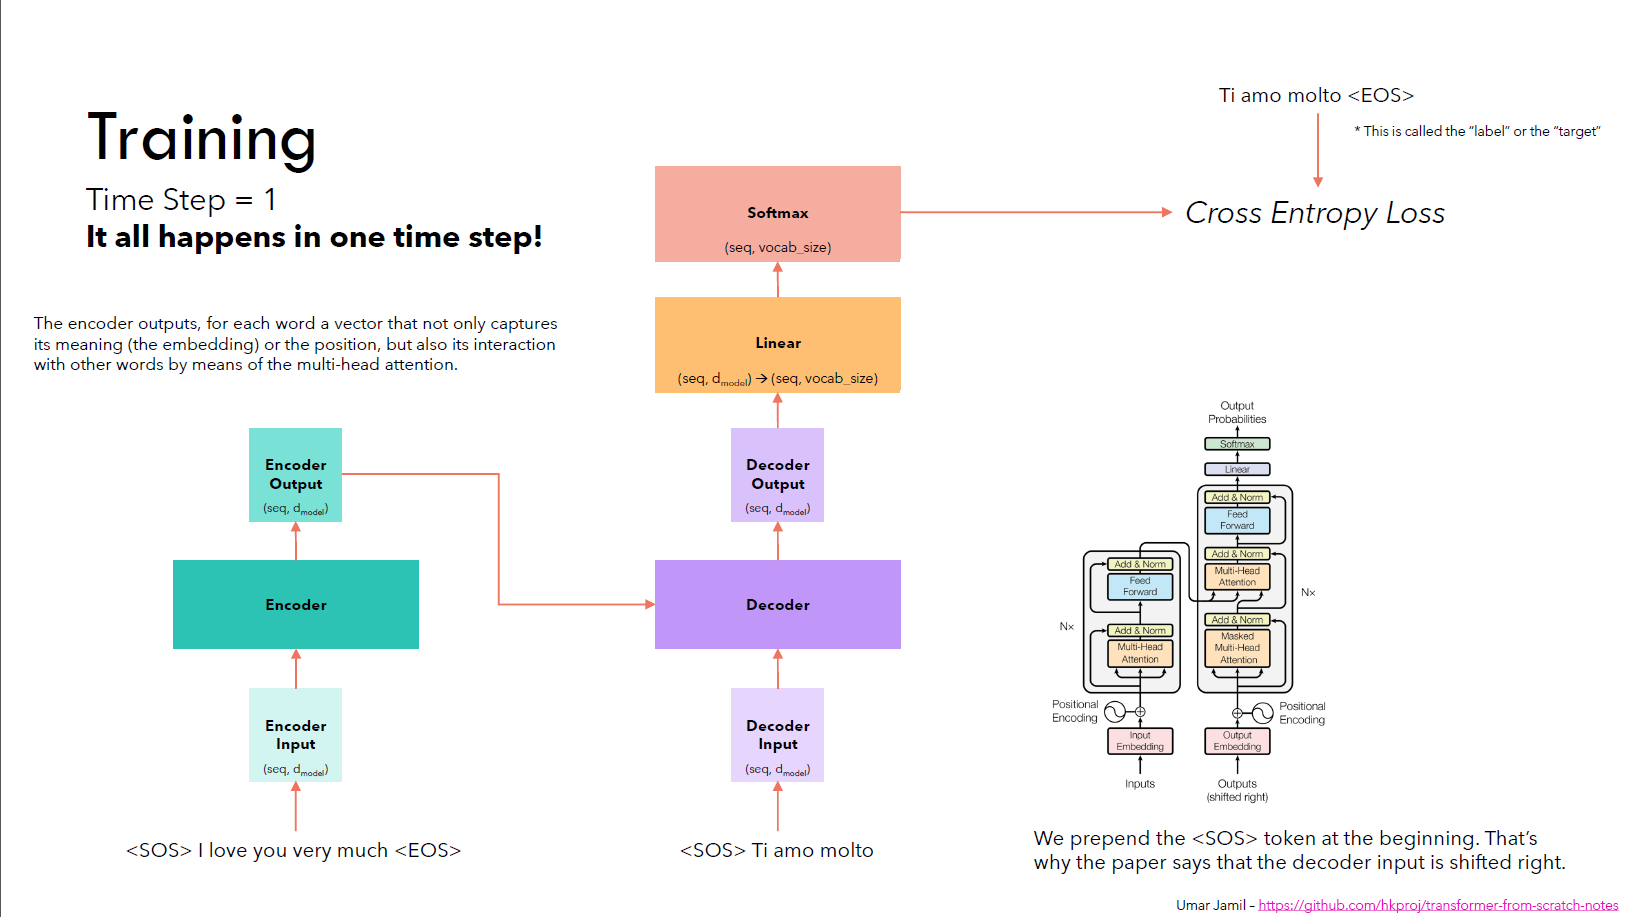

In [ ]:
def collate_fn(examples: List[Dict[str, List[int]]]) -> Dict[str, torch.Tensor]:
    """Collates a list of variable length sequences from the dataset into a batch of PyTorch tensors with padding.

    Args:
        examples: A list of dictionaries, each containing "encoder_input_ids" and "decoder_input_ids".

    Returns:
        A dictionary with padded and collated tensors for encoder and decoder inputs and their corresponding padding masks.
    """

    # Find the maximum sequence length for encoder and decoder inputs in the batch
    encoder_sequence_length = max(len(example["encoder_input_ids"]) for example in examples)
    decoder_sequence_length = max(len(example["decoder_input_ids"]) for example in examples)
    batch_size = len(examples)  # Determine the batch size from the number of examples

    # Initialize tensor for encoder inputs with padding token IDs and proper shape
    encoder_input_ids = torch.full((batch_size, encoder_sequence_length),
                                   fill_value=source_tokenizer.pad_token_id,  # Padding token ID from source tokenizer
                                   dtype=torch.int64)
    # Initialize tensor for encoder padding mask with all values set to True (padding)
    encoder_padding_mask = torch.ones((batch_size, encoder_sequence_length),
                                      dtype=torch.bool)

    # Initialize tensor for decoder inputs with padding token IDs and proper shape
    decoder_input_ids = torch.full((batch_size, decoder_sequence_length),
                                   fill_value=target_tokenizer.pad_token_id,  # Padding token ID from target tokenizer
                                   dtype=torch.int64)
    # Initialize tensor for decoder padding mask with all values set to True (padding)
    decoder_padding_mask = torch.ones((batch_size, decoder_sequence_length),
                                      dtype=torch.bool)

    # Iterate over each example to fill in the actual data and adjust padding masks
    for i, example in enumerate(examples):
        # Copy encoder input IDs into the appropriate slice of the tensor
        encoder_input_ids[i, :len(example["encoder_input_ids"])] = torch.tensor(example["encoder_input_ids"])
        # Adjust the padding mask for actual data (not padding)
        encoder_padding_mask[i, :len(example["encoder_input_ids"])] = False

        # Copy decoder input IDs into the appropriate slice of the tensor
        decoder_input_ids[i, :len(example["decoder_input_ids"])] = torch.tensor(example["decoder_input_ids"])
        # Adjust the padding mask for actual data (not padding)
        decoder_padding_mask[i, :len(example["decoder_input_ids"])] = False

    # Return the collated batch as a dictionary
    return {"encoder_input_ids": encoder_input_ids,
            "encoder_padding_mask": encoder_padding_mask,
            "decoder_input_ids": decoder_input_ids,
            "decoder_padding_mask": decoder_padding_mask}

# Summary of the function:

# Purpose: The `collate_fn` function takes a list of examples containing variable length sequences for encoder and decoder inputs and collates them into a batch of PyTorch tensors with padding.
# It also generates padding masks indicating which positions are padding tokens.

# Detailed breakdown:
# 1. Find the maximum sequence lengths for encoder and decoder inputs in the batch.
# 2. Determine the batch size from the number of examples.
# 3. Initialize tensors for encoder and decoder inputs with padding token IDs and appropriate shapes.
# 4. Initialize tensors for encoder and decoder padding masks with all values set to True (indicating padding).
# 5. Iterate over each example to copy actual data into the initialized tensors and adjust the padding masks.
# 6. Return a dictionary containing the collated tensors for encoder and decoder inputs and their corresponding padding masks.

Next, we provide a simple training loop.

In [ ]:
import time
import math

def compute_loss_per_token(model, batch):
    """Computes the loss per token for a given batch using the provided model.

    Args:
        model: The transformer model.
        batch: A batch of data containing input IDs and padding masks.

    Returns:
        Tensor containing the loss per token.
    """
    # Compute the logits by passing the batch through the model
    logits = model(**batch)

    # Create a mask to exclude padding tokens from the loss computation
    valid_label_mask = ~(batch["decoder_padding_mask"][:, 1:])
    # Extract the labels corresponding to the valid positions
    labels = batch["decoder_input_ids"][:, 1:][valid_label_mask]
    # Extract the logits corresponding to the valid positions
    logits = logits[:, :-1][valid_label_mask]

    # Compute the cross-entropy loss for the valid positions
    return F.cross_entropy(logits, labels, reduction='none')

def evaluate_perplexity(model, dataset, batch_size=32, device="cpu"):
    """Evaluates the model's perplexity on a given dataset.

    Args:
        model: The transformer model.
        dataset: The dataset to evaluate.
        batch_size: The batch size for evaluation.
        device: The device to run the evaluation on (cpu or gpu).

    Returns:
        The perplexity of the model on the dataset.
    """
    model.eval()  # Set the model to evaluation mode

    # Create a DataLoader for the dataset
    dev_loader = torch.utils.data.DataLoader(
        dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

    num_tokens = loss_sum = 0  # Initialize counters for the total number of tokens and the total loss

    # Disable gradient computation
    with torch.no_grad():
        for batch in dev_loader:
            # Move each tensor in the batch to the specified device
            for key in batch:
                batch[key] = batch[key].to(device)

            # Compute the loss per token for the batch
            token_losses = compute_loss_per_token(model, batch)

            # Accumulate the total loss and the number of tokens
            loss_sum += token_losses.sum()
            num_tokens += token_losses.numel()

        # Compute the average perplexity
        dev_ppl = (loss_sum / num_tokens).exp().cpu().item()
    return dev_ppl

def train(model, training_dataset, validation_dataset,
          batch_size=32, lr=1e-3, max_epoch=10, log_every=10, valid_niter=100,
          model_path="model.pt"):
    """Trains the transformer model on the training dataset and evaluates it on the validation dataset.

    Args:
        model: The transformer model.
        training_dataset: The dataset to train on.
        validation_dataset: The dataset to validate on.
        batch_size: The batch size for training and validation.
        lr: The learning rate for the optimizer.
        max_epoch: The maximum number of epochs to train for.
        log_every: The interval (in steps) at which to log training progress.
        valid_niter: The interval (in steps) at which to validate the model.
        model_path: The path to save the best model.
    """
    model.train()  # Set the model to training mode

    # Determine the device to use (GPU if available, otherwise CPU)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print('Use device: %s' % device)

    # Move the model to the specified device
    model = model.to(device)

    # Initialize the Adam optimizer with the model parameters and learning rate
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize training variables
    epoch = global_step = loss_sum = num_tokens = num_examples = 0
    best_valid_perplexity = float('inf')
    train_time = begin_time = time.time()
    print('Beginning maximum likelihood training')

    while True:
        # Create a DataLoader for the training dataset
        train_loader = torch.utils.data.DataLoader(
            training_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
        epoch += 1  # Increment the epoch counter
        batches_per_epoch = len(train_loader)  # Get the number of batches per epoch

        for i, batch in enumerate(train_loader):
            global_step += 1  # Increment the global step counter

            # Move each tensor in the batch to the specified device
            for key in batch:
                batch[key] = batch[key].to(device)

            optimizer.zero_grad()  # Clear the gradients of the optimizer

            # Compute the loss per token for the batch
            token_losses = compute_loss_per_token(model, batch)
            total_loss = token_losses.sum()  # Sum the token losses to get the total loss

            loss = total_loss / batch_size  # Compute the average loss per batch
            loss.backward()  # Backpropagate the loss

            optimizer.step()  # Update the model parameters

            loss_sum += total_loss.cpu().item()  # Accumulate the total loss
            num_tokens += token_losses.numel()  # Accumulate the total number of tokens
            num_examples += batch_size  # Accumulate the total number of examples

            # Log training progress at specified intervals
            if global_step % log_every == 0:
                average_loss = loss_sum / num_examples
                average_ppl = math.exp(loss_sum / num_tokens)
                print(f"epoch {epoch} ({i}/{batches_per_epoch}) | step {global_step} | "
                      f"avg_nll={average_loss:.2f} avg_ppl={average_ppl:.2f} "
                      f"speed={num_tokens / (time.time() - train_time):.2f} words/sec "
                      f"time_elapsed={time.time() - begin_time:.2f} sec")

                train_time = time.time()  # Reset the training time
                loss_sum = num_tokens = num_examples = 0.0  # Reset the accumulated values

            # Validate the model at specified intervals
            if global_step % valid_niter == 0:
                print('Begin validation ...')
                dev_perplexity = evaluate_perplexity(model, validation_dataset, batch_size=batch_size, device=device)

                print(f"validation: step {global_step} | dev_ppl={dev_perplexity}")

                # Save the best model based on validation perplexity
                if dev_perplexity < best_valid_perplexity:
                    best_valid_perplexity = dev_perplexity
                    print(f"epoch {epoch} step {global_step}: save currently the best model to '{model_path}'")
                    torch.save(model.state_dict(), model_path)  # Save model state
                    torch.save(optimizer.state_dict(), model_path + '.optim')  # Save optimizer state
                model.train()  # Set the model back to training mode

        if epoch == max_epoch:
            print('Reached maximum number of epochs')
            break

# Summary of the functions:

# 1. compute_loss_per_token: This function computes the loss per token for a given batch using the provided model.
# It masks out the padding tokens and calculates the cross-entropy loss only for valid positions.

# 2. evaluate_perplexity: This function evaluates the model's perplexity on a given dataset by iterating over the data in batches,
# computing the loss per token, and then calculating the average perplexity.

# 3. train: This function trains the transformer model on the training dataset and evaluates it on the validation dataset.
# It includes functionality for logging training progress, validating the model at regular intervals, and saving the best model based on validation perplexity.


Let's train a relatively small model architecture for 15 epochs.
With a reasonable implementation, this should take about 16 minutes on CPU / 3 minutes on GPU and we should achieve a validation perplexity of below 10!

In [ ]:
# Set a random seed, so you obtain the same output model if you run this cell again.
seed = 42  # Define the seed value for reproducibility.
torch.manual_seed(seed)  # Set the seed for the CPU.
torch.cuda.manual_seed(seed)  # Set the seed for the GPU (if available).

# Instantiate the EncoderDecoderModel with specified hyperparameters
model = EncoderDecoderModel(
    source_vocab_size=source_tokenizer.vocab_size,  # Size of the source vocabulary.
    target_vocab_size=target_tokenizer.vocab_size,  # Size of the target vocabulary.
    hidden_size=32,  # Dimensionality of input and output embeddings.
    intermediate_size=32 * 4,  # Size of the feedforward layers (4 times the hidden size).
    num_attention_heads=4,  # Number of attention heads in each multi-head attention module.
    num_encoder_layers=3,  # Number of transformer blocks in the encoder.
    num_decoder_layers=3,  # Number of transformer blocks in the decoder.
    max_sequence_length=32,  # Maximum sequence length that the model can handle.
    hidden_dropout_prob=0.1,  # Dropout probability in the hidden states.
)

print("Model architecture:", model)  # Print the model architecture.
print("Total number of trainable model parameters:", sum(p.numel() for p in model.parameters() if p.requires_grad))  # Print the total number of trainable parameters in the model.

# Train the model on the training dataset and evaluate it on the validation dataset
train(model, tokenized_datasets["train"], tokenized_datasets["validation"],
      max_epoch=15,  # Maximum number of epochs for training.
      model_path="model.pt")  # Path to save the best model based on validation perplexity.

# Summary of the key steps and classes:

# 1. Setting the random seed ensures reproducibility.
# By setting the seed for both the CPU and GPU, the model initialization and training process will yield the same results each time the code is run.

# 2. The EncoderDecoderModel is instantiated with specific hyperparameters:
#    - source_vocab_size and target_vocab_size specify the size of the vocabularies for the source and target languages, respectively.
#    - hidden_size defines the dimensionality of the input and output embeddings.
#    - intermediate_size is the size of the feedforward layers, set to 4 times the hidden size for this transformer model.
#    - num_attention_heads specifies the number of attention heads in each multi-head attention module.
#    - num_encoder_layers and num_decoder_layers set the number of transformer blocks in the encoder and decoder, respectively.
#    - max_sequence_length defines the maximum sequence length that the model can handle.
#    - hidden_dropout_prob sets the dropout probability for the hidden states to prevent overfitting.

# 3. The model architecture is printed, allowing us to verify the structure of the model.

# 4. The total number of trainable parameters is computed and printed, providing insight into the model's complexity.

# 5. The train function is called to train the model on the training dataset and evaluate it on the validation dataset.
# The model is trained for up to 15 epochs, and the best model based on validation perplexity is saved to the specified path.

Model architecture: EncoderDecoderModel(
  (encoder_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(3200, 32)
    (position_embeddings): Embedding(32, 32)
  )
  (decoder_embeddings): TransformerEmbeddings(
    (token_embeddings): Embedding(3200, 32)
    (position_embeddings): Embedding(32, 32)
  )
  (encoder_layers): ModuleList(
    (0-2): 3 x TransformerBlock(
      (self_attention): MultiHeadAttention(
        (wq): Linear(in_features=32, out_features=32, bias=True)
        (wk): Linear(in_features=32, out_features=32, bias=True)
        (wv): Linear(in_features=32, out_features=32, bias=True)
        (wo): Linear(in_features=32, out_features=32, bias=True)
      )
      (self_attention_layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
      (feedforward): Sequential(
        (0): Linear(in_features=32, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=32, bias=True)
        (3): Dropout(p=0.1, inp

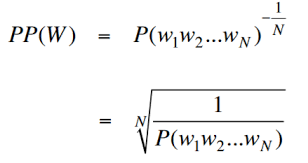

**Perplexity is a measure used to evaluate the performance of language models. It quantifies how well a model predicts the next word or character in a sequence, considering the context provided by preceding elements. Essentially, perplexity reflects the model's "surprise" when encountering new data; lower perplexity scores indicate better predictive accuracy and a stronger understanding of language nuances and structure, leading to more coherent and contextually relevant outcomes.**

**It ranges from 1 to infinity.**

## Evaluate the model

We have trained a seq2seq model for the NMT task. Now let's evaluate the model on the test set by generating translations with beam search and comparing them to the gold translations using the BLEU score.

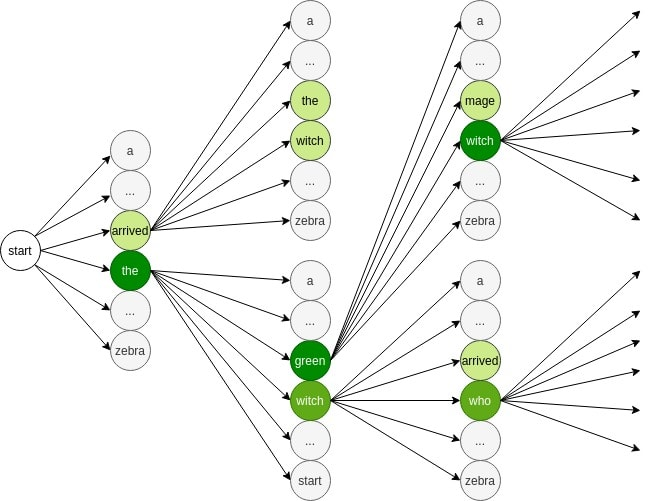

In [ ]:
from tqdm import tqdm  # Import tqdm for progress bar
from nltk.translate.bleu_score import corpus_bleu  # Import BLEU score function

# Performs beam search to generate sequences using the encoder-decoder model.
def beam_search(model: EncoderDecoderModel,
                encoder_input_ids: torch.LongTensor,
                beam_width: int = 5,
                max_len: int = 32) -> Tuple[torch.LongTensor, float]:
    """Run beam search on the encoder-decoder model for a single source sequence.

    Args:
        model: The encoder-decoder model.
        encoder_input_ids: The input sequence. Tensor of shape [encoder_sequence_length].
        beam_width: Number of generations to expand at each time step.
        max_len: Stop generation when reaching this length for the generated sequence.

    Returns:
        A tuple (generation, score) where generation is the generated target sequence and
            a tensor of shape [target_sequence_length] and score is the corresponding
            log-probability of this generation.
    """
    model.eval()  # Set the model to evaluation mode

    encoder_input_ids = encoder_input_ids.unsqueeze(0)  # Add the batch dimension
    encoder_padding_mask = torch.zeros_like(encoder_input_ids, dtype=torch.bool)  # Create a padding mask with no padding
    encoder_outputs = model.forward_encoder(encoder_input_ids, encoder_padding_mask)  # Get encoder outputs

    generations = [torch.tensor([target_tokenizer.bos_token_id], device=encoder_input_ids.device)]  # Initialize generations with BOS token
    scores = [0.0]  # Initialize scores

    best_generation = None  # Initialize the best generation
    best_score = float('-inf')  # Initialize the best score

    for _ in range(max_len):  # Loop until max_len
        new_generations = []  # Initialize list for new generations
        new_scores = []  # Initialize list for new scores
        for score, generation in zip(scores, generations):  # Loop through current scores and generations
            generation = generation.unsqueeze(0)  # Add the batch dimension
            padding_mask = torch.zeros_like(generation, dtype=torch.bool)  # Create a padding mask with no padding
            decoder_output = model.forward_decoder(generation, padding_mask, encoder_outputs, encoder_padding_mask)  # Get decoder outputs
            last_log_probs = decoder_output[0, -1, :].log_softmax(dim=-1)  # Get log probabilities of the last token
            top_log_probs, top_indices = last_log_probs.topk(beam_width, dim=-1)  # Get top k log probabilities and indices

            new_generations.append(torch.cat([generation.expand(beam_width, -1), top_indices[:, None]], dim=1))  # Append new generations
            new_scores.append(score + top_log_probs)  # Append new scores

        new_generations = torch.cat(new_generations, dim=0)  # Concatenate new generations
        new_scores = torch.cat(new_scores, dim=0)  # Concatenate new scores

        ends_with_eos = target_tokenizer.eos_token_id == new_generations[:, -1]  # Check if any generation ends with EOS token

        if ends_with_eos.any():  # If any generation ends with EOS token
            new_completed_generations = new_generations[ends_with_eos]  # Get completed generations
            new_completed_scores = new_scores[ends_with_eos]  # Get completed scores

            if new_completed_scores.max() > best_score:  # If the best score is improved
                best_score = new_completed_scores.max()  # Update the best score
                best_generation = new_completed_generations[new_completed_scores.argmax()]  # Update the best generation

        if best_score >= new_scores.max():  # If the best score is greater than or equal to the maximum score
            break  # Stop the loop

        scores, indices = torch.topk(new_scores, beam_width, dim=-1)  # Get top k scores and indices
        generations = new_generations[indices]  # Update generations

    if best_generation is None:  # If no generation ended with EOS token
        best_generation = generations[0]  # Use the first generation
        best_score = scores[0]  # Use the corresponding score

    return best_generation, best_score.cpu().item()  # Return the best generation and score

# Runs beam search on the test set and computes the BLEU score.
def run_generation(model, test_dataset, beam_size=5, max_decoding_time_step=32):
    """Run beam search decoding on the test set, compute BLEU and return reference and candidate target sentences.
    """

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")  # Use GPU if available, otherwise use CPU
    print('Use device: %s' % device)  # Print the device being used

    input_sentences = []  # Initialize list for input sentences
    reference_sentences = []  # Initialize list for reference sentences
    candidate_sentences = []  # Initialize list for candidate sentences

    with torch.no_grad():  # Disable gradient calculation
        for example in tqdm(test_dataset):  # Loop through the test dataset with progress bar
            encoder_input_ids = torch.tensor(example["encoder_input_ids"], device=device)  # Get encoder input IDs

            generation, _ = beam_search(model, encoder_input_ids, beam_size, max_decoding_time_step)  # Perform beam search

            # Decode given source sequence and generated target sequence and avoid special tokens

            input_text = "".join(source_tokenizer.decode(token).replace("▁", " ") for token in example["encoder_input_ids"][1:-1])  # Decode input tokens
            reference_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in example["decoder_input_ids"][1:-1])  # Decode reference tokens
            candidate_text = "".join(target_tokenizer.decode(token).replace("▁", " ") for token in generation[1:-1].cpu())  # Decode candidate tokens

            reference_sentences.append(reference_text)  # Append reference text
            candidate_sentences.append(candidate_text)  # Append candidate text
            input_sentences.append(input_text)  # Append input text

    bleu_score = corpus_bleu([[ref] for ref in reference_sentences],
                             [candidate for candidate in candidate_sentences])  # Compute BLEU score

    return bleu_score, input_sentences, reference_sentences, candidate_sentences  # Return BLEU score and sentences

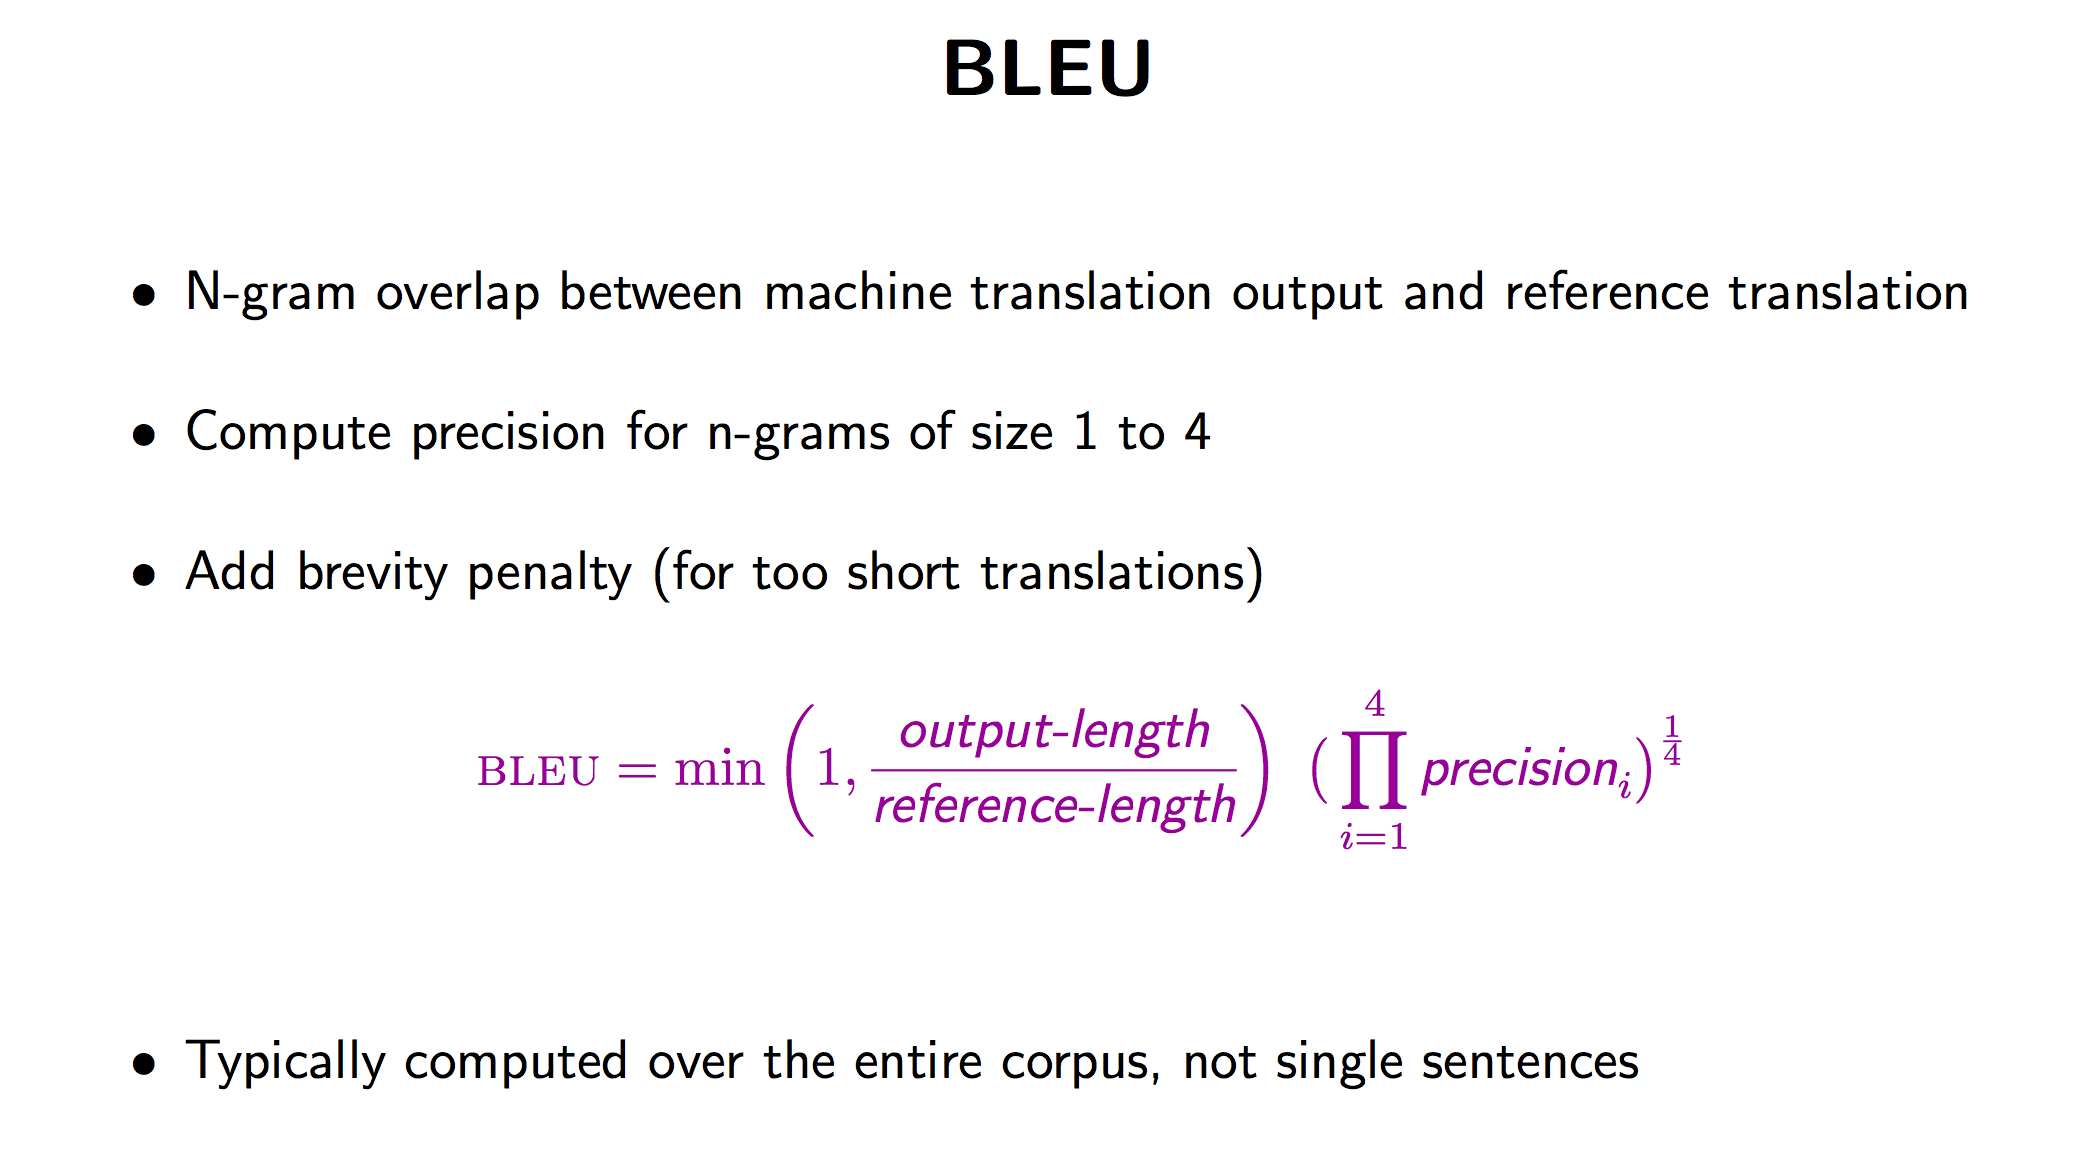

In [ ]:
# Restore the best validation checkpoint
model.load_state_dict(torch.load("model.pt"))  # Load the best model

bleu_score, inputs, references, candidates = run_generation(model, tokenized_datasets["test"])  # Run generation on the test dataset
print('\n\nCorpus BLEU: {}'.format(bleu_score * 100))  # Print the BLEU score

Use device: cpu


100%|██████████| 486/486 [00:45<00:00, 10.72it/s]



Corpus BLEU: 45.08432624981595


Let's look at some examples. What do you think of the quality of the translations?

In [ ]:
# Feel free to change the range to look at more samples!
for k in range(80, 100):
  print(f"===== Sample {k} =====")
  print(f"Input: {inputs[k]}")
  print(f"Gold: {references[k]}")
  print(f"Pred: {candidates[k]}")

===== Sample 80 =====
Input:  je suis desole si je t ai derangee .
Gold:  i m sorry if i disturbed you .
Pred:  i m sorry if i disturbed you .
===== Sample 81 =====
Input:  je suis prepare .
Gold:  i m prepared .
Pred:  i m almost .
===== Sample 82 =====
Input:  vous etes vraiment magnifique .
Gold:  you re really gorgeous .
Pred:  you re really hard .
===== Sample 83 =====
Input:  vous etes fort avisees .
Gold:  you re very wise .
Pred:  you re very wise .
===== Sample 84 =====
Input:  elle est vraiment attentive et patiente .
Gold:  she is very thoughtful and patient .
Pred:  she is really him .
===== Sample 85 =====
Input:  elle va beaucoup mieux aujourd hui .
Gold:  she s much better today .
Pred:  she spoke him .
===== Sample 86 =====
Input:  tu es un merveilleux ami .
Gold:  you re a wonderful friend .
Pred:  you are a friend of friend .
===== Sample 87 =====
Input:  elle a eu du mal a se lever .
Gold:  she struggled to get up .
Pred:  she stopped .
===== Sample 88 =====
Input:  

In [ ]:
def compute_avg_tokens_and_pad_proportion(dataset, batch_size=32):
    total_source_tokens = 0
    total_target_tokens = 0
    total_source_pad_tokens = 0
    total_target_pad_tokens = 0
    num_batches = 0

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

    for batch in data_loader:
        num_batches += 1
        source_tokens = batch["encoder_input_ids"].numel()
        target_tokens = batch["decoder_input_ids"].numel()
        source_pad_tokens = batch["encoder_padding_mask"].sum().item()
        target_pad_tokens = batch["decoder_padding_mask"].sum().item()

        total_source_tokens += source_tokens
        total_target_tokens += target_tokens
        total_source_pad_tokens += source_pad_tokens
        total_target_pad_tokens += target_pad_tokens

    avg_source_tokens = total_source_tokens / num_batches
    avg_target_tokens = total_target_tokens / num_batches
    source_pad_proportion = total_source_pad_tokens / total_source_tokens
    target_pad_proportion = total_target_pad_tokens / total_target_tokens

    return avg_source_tokens, avg_target_tokens, source_pad_proportion, target_pad_proportion

avg_source_tokens, avg_target_tokens, source_pad_proportion, target_pad_proportion = compute_avg_tokens_and_pad_proportion(tokenized_datasets["train"])

print(f"Average number of source tokens per batch: {avg_source_tokens}")
print(f"Average number of target tokens per batch: {avg_target_tokens}")
print(f"Proportion of source <pad> tokens: {source_pad_proportion:.2%}")
print(f"Proportion of target <pad> tokens: {target_pad_proportion:.2%}")


Average number of source tokens per batch: 434.9264705882353
Average number of target tokens per batch: 375.75
Proportion of source <pad> tokens: 33.91%
Proportion of target <pad> tokens: 29.83%


# Questions

Please answer written questions from the assignment in this section. You can alter the provided code to obtain the answers, but be careful not to break anything!

**(b) (4 points)**

- (i)
    What vocabulary size are we using for the source and target language?

- (ii)
    Approximately how many source and target tokens are on average contained in a training batch? What proportion of these tokens are `<pad>` tokens on average?

- (iii)
What is the specific purpose of saving the model parameters in a file `model.pt` throughout training in the code we provide?

**(c) (2 points)**
Manually look at some results and compare them with the gold answers. What do you think of the quality of the translations? Are these grammatical English sentences? Can you identify any common mistakes?

**(d) (4 points)**
Consider the provided beam search method. This implementation is not efficient and performs a lot of repeated computation. Identify the issue and propose how you can fix it.
In particular, describe how would you have to change the arguments and return values of your EncoderDecoderModel and its sub-modules?

## Answer

## **(b)**
# **i)**

Vocab size of source language: 3200

Vocab size of target language: 3200

# **ii)**

Average Number of tokens = batch_size * sequence_length

Percentage of pad tokens = 1- max_length/sequence_length *100%

Average number of source tokens per batch: 434.9264705882353

Average number of target tokens per batch: 375.75

Proportion of source <pad> tokens: 33.91%

Proportion of target <pad> tokens: 29.83%

# **iii)**

**1-Checkpointing:**

Saving the model parameters at regular intervals (or upon improvement in validation performance) helps create checkpoints. This is useful for long training processes, allowing you to resume training from the last saved state if interrupted, rather than starting from scratch.

**2-Selecting the Best Model:**

By monitoring the validation perplexity and saving the model whenever it achieves a new best perplexity, you ensure that you preserve the best-performing version of the model. This way, at the end of training, you have a model that has demonstrated the best performance on the validation set.

## **(c)**

**Grammaticality and Accuracy:**

1. Sample 80:

- Input: je suis desole si je t ai derangee .
- Gold: i m sorry if i disturbed you .
- Pred: i m sorry if i disturbed you .
- Analysis: The prediction is accurate and grammatically correct.

2. Sample 81:

- Input: je suis prepare .
- Gold: i m prepared .
- Pred: i m almost .
- Analysis: The prediction is grammatically incorrect and changes the meaning.

3. Sample 82:

- Input: vous etes vraiment magnifique .
- Gold: you re really gorgeous .
- Pred: you re really hard .
- Analysis: The prediction is grammatically correct but changes the meaning completely.

4. Sample 86:

- Input: tu es un merveilleux ami .
- Gold: you re a wonderful friend .
- Pred: you are a friend of friend .
- Analysis: The prediction is grammatically awkward and less specific.

5. Sample 88:

- Input: vous etes nerveusement use .
- Gold: you re a nervous wreck .
- Pred: you re a nervous .
- Analysis: The prediction is incomplete and changes the meaning.

6. Sample 91:

- Input: je suis plus fort desormais .
- Gold: i m stronger now .
- Pred: i m more
- Analysis: The prediction is incomplete and lacks context.



**Common Mistakes Identified:**

Meaning Changes: Many translations preserve grammatical correctness but significantly alter the meaning of the original sentence.

Incomplete Translations: Several predictions are incomplete, leading to grammatically incorrect or nonsensical sentences.

Incorrect Vocabulary Usage: Incorrect vocabulary choices lead to translations that are contextually inaccurate.

Awkward Constructions: Some translations are awkwardly phrased, impacting fluency and clarity.

**Conclusion:**

The model demonstrates varying quality in its translations. While some translations are accurate and grammatically correct, many suffer from significant meaning changes, incomplete sentences, and incorrect vocabulary usage.



## **(d)**

# **Issue Identification**

**Repeated Computation in Decoder:**

The decoder's computation is repeated for each beam separately at each step. Specifically, model.forward_decoder is called for each generation in the beam individually.

This results in unnecessary repeated calculations since some computations are shared across different beams.

# **Proposed Solution**

To address this, we can leverage batch processing to handle multiple beams simultaneously, which reduces the redundancy in computation. Specifically, we can modify the decoder to accept a batch of sequences and process them in parallel. This involves updating the encoder-decoder model to handle batch inputs efficiently.

# **Changes to EncoderDecoderModel**

**Modify forward_decoder to accept a batch of sequences:**

Update the decoder to process a batch of sequences in one forward pass.
Return the log probabilities for all sequences in the batch simultaneously.

# **Changes in Arguments and Return Values**

**Decoder Input and Output:**

Modify the forward_decoder method in the EncoderDecoderModel to accept a batch of sequences (generations) instead of a single sequence.
Ensure the decoder returns log probabilities for the entire batch.

**Beam Search Process:**

Use tensor operations to handle beam expansion and score calculation.
Update new_generations and new_scores to concatenate and manage batches efficiently.